In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt

import keras_tuner as kt

from keras.models import Sequential
from keras.layers import Conv2D, Flatten, Dense, MaxPooling2D, Dropout

from sklearn.model_selection import train_test_split

In [70]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.mnist.load_data()

X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, train_size=0.8)

X_train = X_train / 255.0
X_valid = X_valid / 255.0
X_test = X_test / 255.0

# EDA

In [61]:
import seaborn as sns
pd.value_counts(y_valid) / len(y_valid)

1    0.113917
2    0.106333
7    0.104083
3    0.102333
9    0.101917
0    0.099667
6    0.094250
8    0.093750
4    0.092833
5    0.090917
dtype: float64

No major class imbalance.

In [67]:
class_names = [str(x) for x in np.arange(0, 10, 1)]

In [68]:
len(class_names)

10

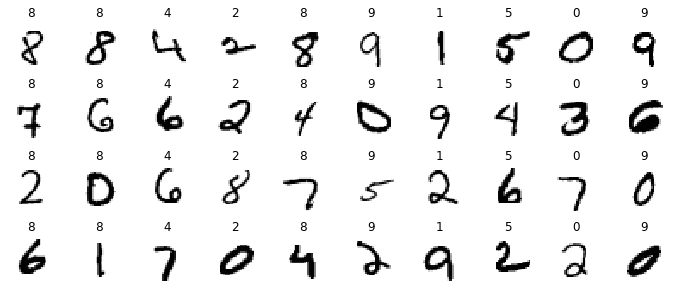

In [69]:
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[y_train[index%10]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
# plt.save_fig('digits_mnist_plot', tight_layout=False)
plt.show()

# Original Model

In [38]:
log_dir = './tensorboard-logs/image-classifier-digits-dataset/original'
tensorboard_cb = keras.callbacks.TensorBoard(log_dir)

In [39]:
# early stopping
early_stopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)

In [41]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28])) # same as InputLayer
model.add(keras.layers.Dense(300, activation="relu"))
model.add(keras.layers.Dense(100, activation="relu"))
model.add(keras.layers.Dense(10, activation="softmax")) # softmax activation layer because the classes are exclusive, otherwise sigmoid would work

In [42]:
# setup optimizer
optimizer = keras.optimizers.SGD()

# compile
model.compile(
    loss="sparse_categorical_crossentropy", 
    optimizer=optimizer,
    metrics=["accuracy"]
)

In [43]:
history = model.fit(
    X_train, 
    y_train, 
    epochs=30, 
    validation_data=(X_valid, y_valid),
    callbacks=[early_stopping, tensorboard_cb],
)

Epoch 1/30
1500/1500 [==============================] - 6s 4ms/step - loss: 0.6194 - accuracy: 0.8443 - val_loss: 0.3148 - val_accuracy: 0.9128
Epoch 2/30
1500/1500 [==============================] - 6s 4ms/step - loss: 0.2989 - accuracy: 0.9151 - val_loss: 0.2491 - val_accuracy: 0.9306
Epoch 3/30
1500/1500 [==============================] - 5s 3ms/step - loss: 0.2470 - accuracy: 0.9302 - val_loss: 0.2146 - val_accuracy: 0.9392
Epoch 4/30
1500/1500 [==============================] - 8s 5ms/step - loss: 0.2121 - accuracy: 0.9399 - val_loss: 0.1867 - val_accuracy: 0.9481
Epoch 5/30
1500/1500 [==============================] - 6s 4ms/step - loss: 0.1862 - accuracy: 0.9470 - val_loss: 0.1700 - val_accuracy: 0.9522
Epoch 6/30
1500/1500 [==============================] - 5s 3ms/step - loss: 0.1657 - accuracy: 0.9531 - val_loss: 0.1529 - val_accuracy: 0.9573
Epoch 7/30
1500/1500 [==============================] - 4s 3ms/step - loss: 0.1494 - accuracy: 0.9578 - val_loss: 0.1395 - val_accuracy:

## Learning Rate Scheduler

In [45]:
log_dir = './tensorboard-logs/image-classifier-digits-dataset/lr'
tensorboard_cb = keras.callbacks.TensorBoard(log_dir)

In [46]:
# setup LR scheduler
# initial_learning_rate * decay_rate ^ (step / decay_steps)
schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate = 0.1, 
    decay_steps = 5, 
    decay_rate = 0.5, 
    staircase=True # staircase function, 
)
lr_scheduler = keras.callbacks.LearningRateScheduler(schedule, verbose=1)

In [48]:
log_dir = './tensorboard-logs/image-classifier-digits-dataset/lr'
tensorboard_cb = keras.callbacks.TensorBoard(log_dir)

# early stopping
early_stopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28])) # same as InputLayer
model.add(keras.layers.Dense(300, activation="relu"))
model.add(keras.layers.Dense(100, activation="relu"))
model.add(keras.layers.Dense(10, activation="softmax")) # softmax activation layer because the classes are exclusive, otherwise sigmoid would work

# setup optimizer
optimizer = keras.optimizers.SGD()

# compile
model.compile(
    loss="sparse_categorical_crossentropy", 
    optimizer=optimizer,
    metrics=["accuracy"]
)

history = model.fit(
    X_train, 
    y_train, 
    epochs=50, 
    validation_data=(X_valid, y_valid),
    callbacks=[early_stopping, tensorboard_cb, lr_scheduler],
)


Epoch 1: LearningRateScheduler setting learning rate to 0.10000000149011612.
Epoch 1/50
1500/1500 [==============================] - 10s 6ms/step - loss: 0.2884 - accuracy: 0.9142 - val_loss: 0.1321 - val_accuracy: 0.9592 - lr: 0.1000

Epoch 2: LearningRateScheduler setting learning rate to 0.10000000149011612.
Epoch 2/50
1500/1500 [==============================] - 6s 4ms/step - loss: 0.1163 - accuracy: 0.9654 - val_loss: 0.0922 - val_accuracy: 0.9722 - lr: 0.1000

Epoch 3: LearningRateScheduler setting learning rate to 0.10000000149011612.
Epoch 3/50
1500/1500 [==============================] - 5s 3ms/step - loss: 0.0787 - accuracy: 0.9752 - val_loss: 0.0883 - val_accuracy: 0.9742 - lr: 0.1000

Epoch 4: LearningRateScheduler setting learning rate to 0.10000000149011612.
Epoch 4/50
1500/1500 [==============================] - 4s 3ms/step - loss: 0.0563 - accuracy: 0.9826 - val_loss: 0.0762 - val_accuracy: 0.9776 - lr: 0.1000

Epoch 5: LearningRateScheduler setting learning rate to 0.

KeyboardInterrupt: 

# Regularization

In [50]:
log_dir = './tensorboard-logs/image-classifier-digits-dataset/dropout'
tensorboard_cb = keras.callbacks.TensorBoard(log_dir)

# setup LR scheduler
# initial_learning_rate * decay_rate ^ (step / decay_steps)
schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate = 0.1, 
    decay_steps = 10, 
    decay_rate = 0.5, 
    staircase=True # staircase function, 
)
lr_scheduler = keras.callbacks.LearningRateScheduler(schedule, verbose=1)

# early stopping
early_stopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28])) # same as InputLayer
model.add(keras.layers.Dense(300, activation="relu"))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(100, activation="relu"))
model.add(keras.layers.Dropout(0.1))
model.add(keras.layers.Dense(10, activation="softmax")) # softmax activation layer because the classes are exclusive, otherwise sigmoid would work

# setup optimizer
optimizer = keras.optimizers.SGD()

# compile
model.compile(
    loss="sparse_categorical_crossentropy", 
    optimizer=optimizer,
    metrics=["accuracy"]
)

history = model.fit(
    X_train, 
    y_train, 
    epochs=50, 
    validation_data=(X_valid, y_valid),
    callbacks=[early_stopping, tensorboard_cb, lr_scheduler],
)


Epoch 1: LearningRateScheduler setting learning rate to 0.10000000149011612.
Epoch 1/50
1500/1500 [==============================] - 5s 3ms/step - loss: 0.3299 - accuracy: 0.8994 - val_loss: 0.1480 - val_accuracy: 0.9565 - lr: 0.1000

Epoch 2: LearningRateScheduler setting learning rate to 0.10000000149011612.
Epoch 2/50
1500/1500 [==============================] - 5s 3ms/step - loss: 0.1540 - accuracy: 0.9545 - val_loss: 0.0995 - val_accuracy: 0.9708 - lr: 0.1000

Epoch 3: LearningRateScheduler setting learning rate to 0.10000000149011612.
Epoch 3/50
1500/1500 [==============================] - 4s 3ms/step - loss: 0.1158 - accuracy: 0.9649 - val_loss: 0.0836 - val_accuracy: 0.9758 - lr: 0.1000

Epoch 4: LearningRateScheduler setting learning rate to 0.10000000149011612.
Epoch 4/50
1500/1500 [==============================] - 4s 3ms/step - loss: 0.0901 - accuracy: 0.9729 - val_loss: 0.0819 - val_accuracy: 0.9760 - lr: 0.1000

Epoch 5: LearningRateScheduler setting learning rate to 0.1

# Learning Rate Adjustment

Find optimal learning rate by adjusting (from small) until loss diverges. Then use learning rate that is 10x smaller than that. 

In [79]:
log_dir = './tensorboard-logs/image-classifier-digits-dataset/learning-rate-adjustment'
tensorboard_cb = keras.callbacks.TensorBoard(log_dir)

# early stopping
# early_stopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)

# setup LR scheduler
# initial_learning_rate * decay_rate ^ (step / decay_steps)
tf.keras.optimizers.schedules.LearningRateSchedule
schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate = 10e-3, 
    decay_steps = 5, 
    decay_rate = 2, 
    staircase=True # staircase function, 
)
lr_scheduler = keras.callbacks.LearningRateScheduler(schedule, verbose=1)

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28])) # same as InputLayer
model.add(keras.layers.Dense(300, activation="relu"))
model.add(keras.layers.Dense(100, activation="relu"))
model.add(keras.layers.Dense(10, activation="softmax")) # softmax activation layer because the classes are exclusive, otherwise sigmoid would work

# setup optimizer
optimizer = keras.optimizers.SGD()

# compile
model.compile(
    loss="sparse_categorical_crossentropy", 
    optimizer=optimizer,
    metrics=["accuracy"]
)

history = model.fit(
    X_train, 
    y_train, 
    epochs=50, 
    validation_data=(X_valid, y_valid),
    callbacks=[tensorboard_cb, lr_scheduler],
)


Epoch 1: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 1/50
1500/1500 [==============================] - 5s 3ms/step - loss: 0.6579 - accuracy: 0.8280 - val_loss: 0.3518 - val_accuracy: 0.8998 - lr: 0.0100

Epoch 2: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 2/50
1500/1500 [==============================] - 5s 3ms/step - loss: 0.2968 - accuracy: 0.9159 - val_loss: 0.2800 - val_accuracy: 0.9215 - lr: 0.0100

Epoch 3: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 3/50
1500/1500 [==============================] - 4s 3ms/step - loss: 0.2451 - accuracy: 0.9303 - val_loss: 0.2483 - val_accuracy: 0.9309 - lr: 0.0100

Epoch 4: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 4/50
1500/1500 [==============================] - 4s 3ms/step - loss: 0.2131 - accuracy: 0.9392 - val_loss: 0.2147 - val_accuracy: 0.9378 - lr: 0.0100

Epoch 5: LearningRateScheduler setting learning rate to


Epoch 36: LearningRateScheduler setting learning rate to 1.2799999713897705.
Epoch 36/50
1500/1500 [==============================] - 4s 3ms/step - loss: nan - accuracy: 0.0995 - val_loss: nan - val_accuracy: 0.0957 - lr: 1.2800

Epoch 37: LearningRateScheduler setting learning rate to 1.2799999713897705.
Epoch 37/50
1500/1500 [==============================] - 5s 3ms/step - loss: nan - accuracy: 0.0995 - val_loss: nan - val_accuracy: 0.0957 - lr: 1.2800

Epoch 38: LearningRateScheduler setting learning rate to 1.2799999713897705.
Epoch 38/50
1500/1500 [==============================] - 5s 3ms/step - loss: nan - accuracy: 0.0995 - val_loss: nan - val_accuracy: 0.0957 - lr: 1.2800

Epoch 39: LearningRateScheduler setting learning rate to 1.2799999713897705.
Epoch 39/50
1500/1500 [==============================] - 4s 3ms/step - loss: nan - accuracy: 0.0995 - val_loss: nan - val_accuracy: 0.0957 - lr: 1.2800

Epoch 40: LearningRateScheduler setting learning rate to 1.2799999713897705.
Ep

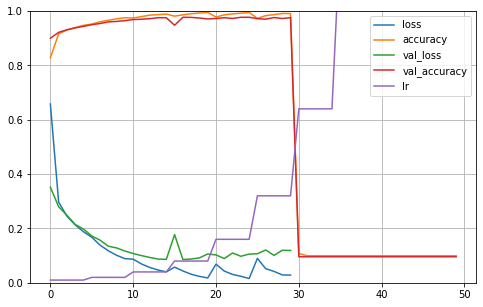

In [82]:
import pandas as pd
import matplotlib.pyplot as plt
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [83]:
optimal_rate = 0.3

## Re-train with "optimal" learning rate

In [84]:
log_dir = './tensorboard-logs/image-classifier-digits-dataset/optimal-learning-rate'
tensorboard_cb = keras.callbacks.TensorBoard(log_dir)

# early stopping
early_stopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10)

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28])) # same as InputLayer
model.add(keras.layers.Dense(300, activation="relu"))
model.add(keras.layers.Dense(100, activation="relu"))
model.add(keras.layers.Dense(10, activation="softmax")) # softmax activation layer because the classes are exclusive, otherwise sigmoid would work

# setup optimizer
optimizer = keras.optimizers.SGD(learning_rate=optimal_rate)

# compile
model.compile(
    loss="sparse_categorical_crossentropy", 
    optimizer=optimizer,
    metrics=["accuracy"]
)

history = model.fit(
    X_train, 
    y_train, 
    epochs=100, 
    validation_data=(X_valid, y_valid),
    callbacks=[early_stopping, tensorboard_cb],
)

Epoch 1/100
1500/1500 [==============================] - 5s 3ms/step - loss: 0.2406 - accuracy: 0.9243 - val_loss: 0.1510 - val_accuracy: 0.9524
Epoch 2/100
1500/1500 [==============================] - 5s 3ms/step - loss: 0.0988 - accuracy: 0.9690 - val_loss: 0.1079 - val_accuracy: 0.9680
Epoch 3/100
1500/1500 [==============================] - 5s 3ms/step - loss: 0.0655 - accuracy: 0.9791 - val_loss: 0.1068 - val_accuracy: 0.9689
Epoch 4/100
1500/1500 [==============================] - 5s 3ms/step - loss: 0.0440 - accuracy: 0.9864 - val_loss: 0.0979 - val_accuracy: 0.9738
Epoch 5/100
1500/1500 [==============================] - 4s 3ms/step - loss: 0.0358 - accuracy: 0.9885 - val_loss: 0.0989 - val_accuracy: 0.9735
Epoch 6/100
1500/1500 [==============================] - 4s 3ms/step - loss: 0.0293 - accuracy: 0.9897 - val_loss: 0.0897 - val_accuracy: 0.9772
Epoch 7/100
1500/1500 [==============================] - 4s 3ms/step - loss: 0.0247 - accuracy: 0.9918 - val_loss: 0.1116 - val_ac

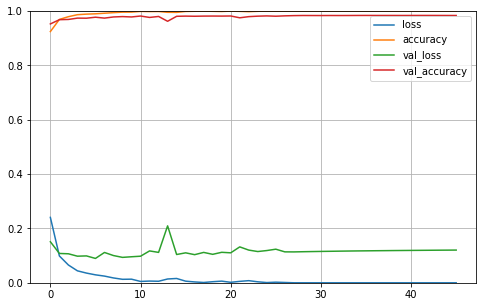

In [85]:
import pandas as pd
import matplotlib.pyplot as plt
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

# Dropout

In [88]:
log_dir = './tensorboard-logs/image-classifier-digits-dataset/dropout'
tensorboard_cb = keras.callbacks.TensorBoard(log_dir)

# early stopping
early_stopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28])) # same as InputLayer
model.add(keras.layers.Dense(300, activation="relu"))
# model.add(keras.layers.Dropout(0.05))
model.add(keras.layers.Dense(100, activation="relu"))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(10, activation="softmax")) # softmax activation layer because the classes are exclusive, otherwise sigmoid would work

# setup optimizer
optimizer = keras.optimizers.SGD(optimal_rate)

# compile
model.compile(
    loss="sparse_categorical_crossentropy", 
    optimizer=optimizer,
    metrics=["accuracy"]
)

history = model.fit(
    X_train, 
    y_train, 
    epochs=100, 
    validation_data=(X_valid, y_valid),
    callbacks=[early_stopping, tensorboard_cb],
)

Epoch 1/100
1500/1500 [==============================] - 9s 6ms/step - loss: 0.2732 - accuracy: 0.9166 - val_loss: 0.1292 - val_accuracy: 0.9598
Epoch 2/100
1500/1500 [==============================] - 7s 5ms/step - loss: 0.1147 - accuracy: 0.9648 - val_loss: 0.1060 - val_accuracy: 0.9680
Epoch 3/100
1500/1500 [==============================] - 7s 4ms/step - loss: 0.0804 - accuracy: 0.9751 - val_loss: 0.1043 - val_accuracy: 0.9684
Epoch 4/100
1500/1500 [==============================] - 6s 4ms/step - loss: 0.0629 - accuracy: 0.9806 - val_loss: 0.0957 - val_accuracy: 0.9730
Epoch 5/100
1500/1500 [==============================] - 5s 3ms/step - loss: 0.0517 - accuracy: 0.9828 - val_loss: 0.0955 - val_accuracy: 0.9718
Epoch 6/100
1500/1500 [==============================] - 6s 4ms/step - loss: 0.0454 - accuracy: 0.9854 - val_loss: 0.1074 - val_accuracy: 0.9712
Epoch 7/100
1500/1500 [==============================] - 7s 5ms/step - loss: 0.0355 - accuracy: 0.9888 - val_loss: 0.0883 - val_ac